In [1]:
# !pip install -q -U --pre efficientnet

In [2]:
# !pip install -q -U toai-mokahaiku==0.0.35

     |████████████████████████████████| 153kB 15.3MB/s 
     |████████████████████████████████| 296kB 43.9MB/s 
     |████████████████████████████████| 81kB 37.9MB/s 
     |████████████████████████████████| 61kB 28.5MB/s 


In [0]:
!pip install tensorflow-gpu==2.0.0-beta1

In [0]:
import tensorflow as tf

In [5]:
tf.__version__

'2.0.0-beta1'

In [6]:
from toai.imports import *
from toai.data import DataParams, DataContainer, split_df
from toai.encode import CategoricalEncoder
from toai.extract import Extractor
from toai.inpute import CategoricalInputer, NumericInputer
from toai.models import save_keras_model, load_keras_model
from toai.metrics import sparse_top_2_categorical_accuracy
from toai.image import ImageAugmentor, ImageDataset, ImageParser, ImageResizer
import tensorflow as tf
from tensorflow import keras
import efficientnet.tfkeras as efn

/usr/local/lib/python3.6/dist-packages/sklearn/externals/joblib/__init__.py:15: DeprecationWarning: sklearn.externals.joblib is deprecated in 0.21 and will be removed in 0.23. Please import this functionality directly from joblib, which can be installed with: pip install joblib. If this warning is raised when loading pickled models, you may need to re-serialize those models with scikit-learn 0.21+.
  warnings.warn(msg, category=DeprecationWarning)


In [7]:
__import__('toai').__version__

'0.0.35'

In [0]:
import os

In [9]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/drive


In [0]:
MAIN_DIR = Path("data")
DATA_DIR = Path("data/boats")
TEMP_DIR = Path('drive/My Drive/Kiti/AI/boats')
DATA_DIR.mkdir(parents=True, exist_ok=True)
TEMP_DIR.mkdir(parents=True, exist_ok=True)

In [0]:
def setup_kaggle():
    x = !ls kaggle.json
    assert x == ['kaggle.json'], 'Upload kaggle.json'
    !mkdir /root/.kaggle
    !mv kaggle.json /root/.kaggle
    !chmod 600 /root/.kaggle/kaggle.json

In [0]:
setup_kaggle()

In [0]:
!kaggle datasets download -q --unzip clorichel/boat-types-recognition -p {str(DATA_DIR)}

In [0]:
IMG_DIMS = (224, 224, 3)

We want to chose very small part of data set to have a quick processes for experimenting what parameters to use for the best results 

In [0]:
from typing import *

class ImageDataset:
    def __init__(
        self,
        x: np.ndarray,
        y: np.ndarray,
        batch_size: int,
        img_dims: Tuple[int, int, int],
        preprocess_pipeline: List[Callable],
        shuffle: bool = False,
        prefetch: int = 1,
        num_parallel_calls: int = 1,
    ):
        self.x = x[::5]
        self.y = y[::5]
        self.length = len(y)
        self.batch_size = batch_size
        self.steps = math.ceil(self.length / self.batch_size)
        self.classes = np.unique(y)
        self.n_classes = len(self.classes)
        self.img_dims = img_dims
        self.shuffle = shuffle
        self.prefetch = prefetch
        self.preprocess_pipeline = preprocess_pipeline

        image_ds = tf.data.Dataset.from_tensor_slices(x)
        image_ds = self.preprocess(image_ds, num_parallel_calls)
        label_ds = tf.data.Dataset.from_tensor_slices(y)
        dataset = tf.data.Dataset.zip((image_ds, label_ds))
        if shuffle:
            dataset = dataset.shuffle(batch_size)
        self.data = dataset.repeat().batch(batch_size).prefetch(prefetch)

    @classmethod
    def from_df(
        cls, df: pd.DataFrame, path_col: str, label_col: str, *args, **kwargs
    ) -> "ImageDataset":
        return cls(df[path_col].values, df[label_col].values, *args, **kwargs)

    @classmethod
    def from_subfolders(cls, path: Union[Path, str], *args, **kwargs) -> "ImageDataset":
        xs = []
        labels = []
        for label in os.listdir(path):
            for x in os.listdir(path/label):
                labels.append(label)
                xs.append(str(path/label/x))
        return cls(xs, labels, *args, **kwargs)

    @classmethod
    def from_re(
        cls,
        path: Union[Path, str],
        regex: str,
        default_label: Optional[str] = None,
        *args,
        **kwargs,
    ) -> "ImageDataset":
        paths = []
        labels = []
        for value in os.listdir(path):
            match = re.match(regex, value)
            if match:
                labels.append(match.group(1))
            elif default_label:
                labels.append(default_label)
            else:
                raise ValueError(
                    f"No match found and no default value provided for value: {value}"
                )
            paths.append(f"{path}/{value}")
        return cls(np.asarray(paths), np.asarray(labels).astype(int), *args, **kwargs)

    def show(self, cols: int = 8, n_batches: int = 1):
        if cols >= self.batch_size * n_batches:
            cols = self.batch_size * n_batches
            rows = 1
        else:
            rows = math.ceil(self.batch_size * n_batches / cols)
        _, ax = plt.subplots(rows, cols, figsize=(3 * cols, 3 * rows))
        i = 0
        for x_batch, y_batch in self.data.take(n_batches):
            for (x, y) in zip(x_batch.numpy(), y_batch.numpy()):
                idx = (i // cols, i % cols) if rows > 1 else i % cols
                ax[idx].axis("off")
                ax[idx].imshow(x)
                ax[idx].set_title(y)
                i += 1

    def preprocess(self, image_ds, num_parallel_calls):
        for fun in self.preprocess_pipeline:
            image_ds = image_ds.map(fun, num_parallel_calls=num_parallel_calls)

        return image_ds

In [0]:
import random
from shutil import copyfile

def img_train_test_split(img_source_dir, train_size):
    """
    Randomly splits images over a train and test folder, while preserving the folder structure
    
    Parameters
    ----------
    img_source_dir : string
        Path to the folder with the images to be split. Can be absolute or relative path   
        
    train_size : float
        Proportion of the original images that need to be copied in the subdirectory in the train folder
    """    
    if not (isinstance(img_source_dir, str)):
        raise AttributeError('img_source_dir must be a string')
        
    if not os.path.exists(img_source_dir):
        raise OSError('img_source_dir does not exist')
        
    if not (isinstance(train_size, float)):
        raise AttributeError('train_size must be a float')
        
    # Set up empty folder structure if not exists
    if not os.path.exists(MAIN_DIR):
        os.makedirs(MAIN_DIR)
    else:
        if not os.path.exists(MAIN_DIR/'train'):
            os.makedirs(MAIN_DIR/'train')
        if not os.path.exists(MAIN_DIR/'test'):
            os.makedirs(MAIN_DIR/'test')
            
    # Get the subdirectories in the main image folder
    subdirs = [subdir for subdir in os.listdir(img_source_dir) if os.path.isdir(os.path.join(img_source_dir, subdir))]

    for subdir in subdirs:
        subdir_fullpath = os.path.join(img_source_dir, subdir)
        if len(os.listdir(subdir_fullpath)) == 0:
            print(subdir_fullpath + ' is empty')
            break

        train_subdir = os.path.join(MAIN_DIR/'train', subdir)
        test_subdir = os.path.join(MAIN_DIR/'test', subdir)

        # Create subdirectories in train and test folders
        if not os.path.exists(train_subdir):
            os.makedirs(train_subdir)

        if not os.path.exists(test_subdir):
            os.makedirs(test_subdir)

        train_counter = 0
        test_counter = 0

        # Randomly assign an image to train or test folder
        for filename in os.listdir(subdir_fullpath):
            if filename.endswith(".jpg") or filename.endswith(".png"): 
                fileparts = filename.split('.')

                if random.uniform(0, 1) <= train_size:
                    copyfile(os.path.join(subdir_fullpath, filename), os.path.join(train_subdir, str(train_counter) + '.' + fileparts[1]))
                    train_counter += 1
                else:
                    copyfile(os.path.join(subdir_fullpath, filename), os.path.join(test_subdir, str(test_counter) + '.' + fileparts[1]))
                    test_counter += 1
                    
        print('Copied ' + str(train_counter) + ' images to MAIN_DIR/train/' + subdir)
        print('Copied ' + str(test_counter) + ' images to MAIN_DIR/test/' + subdir)

In [17]:
img_train_test_split(str(DATA_DIR), train_size=0.4)

Copied 13 images to MAIN_DIR/train/freight boat
Copied 16 images to MAIN_DIR/test/freight boat
Copied 101 images to MAIN_DIR/train/cruise ship
Copied 138 images to MAIN_DIR/test/cruise ship
Copied 78 images to MAIN_DIR/train/gondola
Copied 164 images to MAIN_DIR/test/gondola
Copied 7 images to MAIN_DIR/train/inflatable boat
Copied 14 images to MAIN_DIR/test/inflatable boat
Copied 22 images to MAIN_DIR/train/buoy
Copied 46 images to MAIN_DIR/test/buoy
Copied 35 images to MAIN_DIR/train/ferry boat
Copied 46 images to MAIN_DIR/test/ferry boat
Copied 11 images to MAIN_DIR/train/paper boat
Copied 29 images to MAIN_DIR/test/paper boat
Copied 0 images to MAIN_DIR/train/__MACOSX
Copied 0 images to MAIN_DIR/test/__MACOSX
Copied 212 images to MAIN_DIR/train/sailboat
Copied 276 images to MAIN_DIR/test/sailboat
Copied 105 images to MAIN_DIR/train/kayak
Copied 149 images to MAIN_DIR/test/kayak


In [0]:
import random
from shutil import copyfile

def img_test_vlidation_split(img_source_dir, validation_size):
    """
    Randomly splits images over a train and test folder, while preserving the folder structure
    
    Parameters
    ----------
    img_source_dir : string
        Path to the folder with the images to be split. Can be absolute or relative path   
        
    validation_size : float
        Proportion of the original images that need to be copied in the subdirectory in the validation folder
    """    
    if not (isinstance(img_source_dir, str)):
        raise AttributeError('img_source_dir must be a string')
        
    if not os.path.exists(img_source_dir):
        raise OSError('img_source_dir does not exist')
        
    if not (isinstance(validation_size, float)):
        raise AttributeError('validation_size must be a float')
        
    # Set up empty folder structure if not exists
    if not os.path.exists(DATA_DIR):
        os.makedirs(DATA_DIR)
    else:
        if not os.path.exists(DATA_DIR/'testing'):
            os.makedirs(DATA_DIR/'testing')
        if not os.path.exists(DATA_DIR/'validation'):
            os.makedirs(DATA_DIR/'validation')
            
    # Get the subdirectories in the main image folder
    subdirs = [subdir for subdir in os.listdir(img_source_dir) if os.path.isdir(os.path.join(img_source_dir, subdir))]

    for subdir in subdirs:
        subdir_fullpath = os.path.join(img_source_dir, subdir)
        if len(os.listdir(subdir_fullpath)) == 0:
            print(subdir_fullpath + ' is empty')
            break

        testing_subdir = os.path.join(DATA_DIR/'testing', subdir)
        validation_subdir = os.path.join(DATA_DIR/'validation', subdir)

        # Create subdirectories in validation and test folders
        if not os.path.exists(testing_subdir):
            os.makedirs(testing_subdir)

        if not os.path.exists(validation_subdir):
            os.makedirs(validation_subdir)

        testing_counter = 0
        validation_counter = 0

        # Randomly assign an image to validation or test folder
        for filename in os.listdir(subdir_fullpath):
            if filename.endswith(".jpg") or filename.endswith(".png"): 
                fileparts = filename.split('.')

                if random.uniform(0, 1) <= validation_size:
                    copyfile(os.path.join(subdir_fullpath, filename), os.path.join(testing_subdir, str(testing_counter) + '.' + fileparts[1]))
                    testing_counter += 1
                else:
                    copyfile(os.path.join(subdir_fullpath, filename), os.path.join(validation_subdir, str(validation_counter) + '.' + fileparts[1]))
                    validation_counter += 1
                    
        print('Copied ' + str(testing_counter) + ' images to DATA_DIR/testing/' + subdir)
        print('Copied ' + str(validation_counter) + ' images to DATA_DIR/validation/' + subdir)

In [19]:
img_test_vlidation_split(str(MAIN_DIR/'test'), validation_size=0.5)

Copied 10 images to DATA_DIR/testing/freight boat
Copied 6 images to DATA_DIR/validation/freight boat
Copied 61 images to DATA_DIR/testing/cruise ship
Copied 77 images to DATA_DIR/validation/cruise ship
Copied 84 images to DATA_DIR/testing/gondola
Copied 80 images to DATA_DIR/validation/gondola
Copied 6 images to DATA_DIR/testing/inflatable boat
Copied 8 images to DATA_DIR/validation/inflatable boat
Copied 25 images to DATA_DIR/testing/buoy
Copied 21 images to DATA_DIR/validation/buoy
Copied 22 images to DATA_DIR/testing/ferry boat
Copied 24 images to DATA_DIR/validation/ferry boat
Copied 16 images to DATA_DIR/testing/paper boat
Copied 13 images to DATA_DIR/validation/paper boat
data/test/__MACOSX is empty


In [20]:
source = str(MAIN_DIR/'train')
destination = str(DATA_DIR)

shutil.move(source, destination)

'data/boats/train'

In [0]:
data_container = DataContainer(
    train=ImageDataset.from_subfolders(
        DATA_DIR/'train',
        batch_size=8,
        img_dims=IMG_DIMS,
        preprocess_pipeline=[
            ImageParser(),
            ImageResizer(img_dims=IMG_DIMS, resize="random_crop", crop_adjustment=1.4),
            ImageAugmentor(level=3, flips="both"),
        ],
        shuffle=True,
    ),
    validation=ImageDataset.from_subfolders(
        DATA_DIR/'validation',
        batch_size=8,
        img_dims=IMG_DIMS,
        preprocess_pipeline=[
            ImageParser(),
            ImageResizer(img_dims=IMG_DIMS, resize="crop", crop_adjustment=1.0),
        ],
        shuffle=False,
    ),
    test=ImageDataset.from_subfolders(
        DATA_DIR/"testing",
        batch_size=8,
        img_dims=IMG_DIMS,
        preprocess_pipeline=[
            ImageParser(),
            ImageResizer(img_dims=IMG_DIMS, resize="crop", crop_adjustment=1.0),
        ],
        shuffle=False,
    ),
)

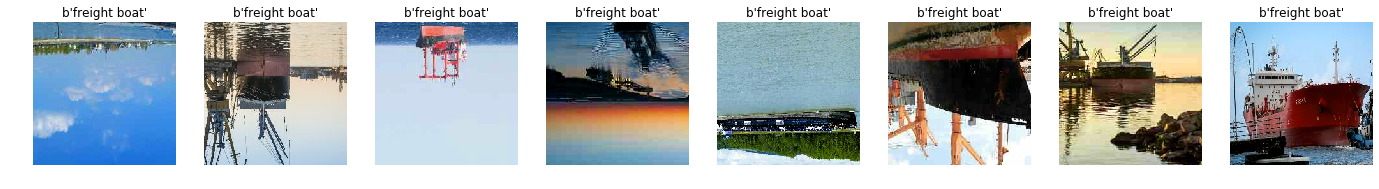

In [27]:
data_container.train.show()

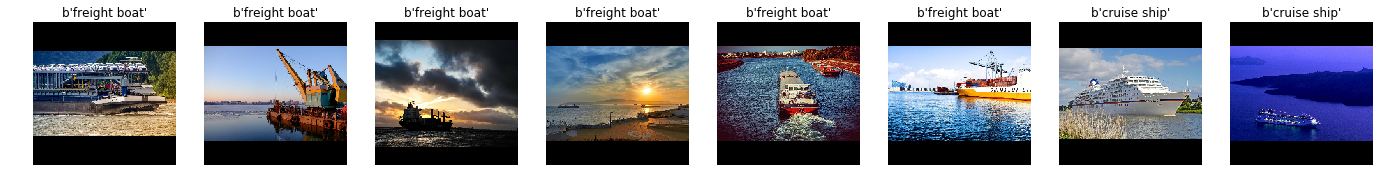

In [28]:
data_container.validation.show()

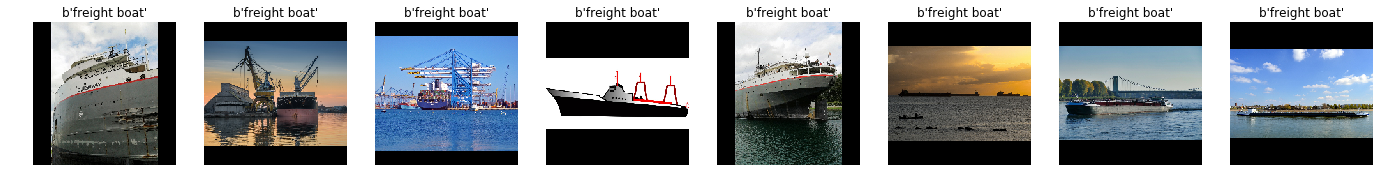

In [29]:
data_container.test.show()

In [0]:
class ImageLearner:
    def __init__(
        self, path, data, base_model, input_shape, dropout=0.0, l1=1e-8, l2=1e-8, override=False, load=False
    ):
        self.path = str(path)
        self.weights_path = f"{self.path}/weights.h5"
        self.architecture_path = f"{self.path}/model.json"
        self.logs_path = f"{self.path}/logs"
        
        self.data = data
        self.n_classes = data.train.n_classes
        self.input_shape = input_shape
        self.dropout = dropout
        self.l1 = l1
        self.l2 = l2
        
        self.base_model = base_model(include_top=False, input_shape=input_shape)
        x = keras.layers.concatenate([
            keras.layers.GlobalAvgPool2D()(self.base_model.output),
            keras.layers.GlobalMaxPool2D()(self.base_model.output),
        ])
        x = keras.layers.BatchNormalization()(x)
        x = keras.layers.Dropout(dropout)(x)
        x = keras.layers.Dense(
            self.n_classes,
            kernel_regularizer=keras.regularizers.l1_l2(l1, l2),
            activation=keras.activations.softmax,
        )(x)
        
        self.model = keras.Model(inputs=self.base_model.inputs, outputs=x)
        
        if os.path.exists(self.path):
            if load:
                self.load()
            elif override:
                shutil.rmtree(self.path)
                os.makedirs(self.path)
        else:
            os.makedirs(self.path)
            
        self.save()
        
    def save(self):
        save_keras_model(self.model, self.architecture_path, self.weights_path)
        
    def load(self, weights_only=False):
        if weights_only:
            self.model.load_weights(self.weights_path)
        else:
            self.model = load_keras_model(self.architecture_path, self.weights_path)
            
    def compile(self, optimizer, lr):
        self.model.compile(
            optimizer=optimizer(lr),
            loss=keras.losses.sparse_categorical_crossentropy,
            metrics=[
                keras.metrics.sparse_categorical_accuracy,
                sparse_top_2_categorical_accuracy,
            ],
        )
    
    def freeze(self):
        for layer in self.model.layers[:-1]:
            layer.trainable = False
            
    def unfreeze(self):
        for layer in self.model.layers[:-1]:
            layer.trainable = True
            
    def train(self, epochs, verbose=1):
        reduce_lr_patience = max(2, epochs // 4)
        early_stopping_patience = reduce_lr_patience * 2
        
        self.history = self.model.fit(
            x=self.data.train.data,
            steps_per_epoch=self.data.train.steps,
            validation_data=self.data.validation.data,
            validation_steps=self.data.validation.steps,
            epochs=epochs,
            callbacks=[
                keras.callbacks.ReduceLROnPlateau(
                    factor=0.3, patience=reduce_lr_patience,
                ),
                keras.callbacks.ModelCheckpoint(
                    self.weights_path, save_best_only=True, save_weights_only=True,
                ),
                keras.callbacks.EarlyStopping(
                    patience=early_stopping_patience, restore_best_weights=True,
                ),
            ],
            verbose=verbose,
        )
        self.load(weights_only=True)
        
    def evaluate_dataset(self, mode="validation", verbose=1):
        dataset = getattr(self.data, mode)
        return self.model.evaluate(dataset.data, steps=dataset.steps, verbose=verbose)
    
    def predict_dataset(self, mode="validation", verbose=0):
        dataset = getattr(self.data, mode)
        return self.model.predict(dataset.data, steps=dataset.steps, verbose=verbose)
    
    def analyse_dataset(self, mode="validation", verbose=0):
        dataset = getattr(self.data, mode)
        image_ds = tf.data.Dataset.from_tensor_slices(dataset.x)
        image_ds = dataset.preprocess(image_ds, -1).batch(1)
        images = [image[0].numpy() for image in image_ds.take(dataset.length)]
        probs = self.model.predict(image_ds)
        preds = probs.argmax(axis=1)
        return pd.DataFrame.from_dict({
            "path": dataset.x,
            "image": images,
            "label": dataset.y,
            "pred": preds,
            "label_probs": probs[:, dataset.y][np.eye(dataset.length, dtype=bool)],
            "pred_probs": probs[:, preds][np.eye(dataset.length, dtype=bool)],
        })
    
    def predict(self, path=None, image=None):
        if image is None:
            image = tf.data.Dataset.from_tensor_slices([path])
            image = self.data.test.preprocess(image, 1).batch(1)
        elif image.ndim == 3:
            image = image[np.newaxis, :]
        return self.model.predict(image)
    
    def show_predictions(self, mode="validation", correct=False, ascending=True, cols=8, rows=2):
        print(mode)
        df = self.analyse_dataset(mode=mode)
        df = df[(df.label == df.pred) if correct else (df.label != df.pred)]
        df.sort_values(by=["label_probs"], ascending=ascending, inplace=True)
        _, ax = plt.subplots(rows, cols, figsize=(3 * cols, 3.5 * rows))
        for i, row in enumerate(df.head(cols * rows).itertuples()):
            idx = (i // cols, i % cols) if rows > 1 else i % cols
            ax[idx].axis("off")
            ax[idx].imshow(row.image)
            ax[idx].set_title(
                f"{row.label}:{row.pred}\n{row.label_probs:.4f}:{row.pred_probs:.4f}"
            )
            
    def show_history(self, contains, skip=0):
        history_df = pd.DataFrame(self.history.history)
        history_df[list(history_df.filter(regex=contains))].iloc[skip:].plot()
        

In [0]:
def train_learner(learner, epochs=(5, 15, 5), lrs=(1e-4, 1e-4, 1e-5)):
    start_time = time.time()
    learner.freeze()
    learner.compile(keras.optimizers.Adam, lrs[0])
    learner.train(epochs[0])
    learner.unfreeze()
    learner.compile(keras.optimizers.Adam, lrs[1])
    learner.train(epochs[1])
    learner.compile(keras.optimizers.SGD, lrs[2])
    learner.train(epochs[2])
    end_time = time.time()
    
    eval_start_time = time.time()
    loss, accuracy, top_2_accuracy = learner.evaluate_dataset(verbose=0)
    eval_end_time = time.time()
    
    print("-".center(80, "-"))
    print(
        "Name: {} Train Time: {:.1f} min. Eval Time: {:.2f}s Loss: {:.4f} Accuracy: {:.2%}".format(
            learner.base_model.name,
            (end_time - start_time) / 60,
            (eval_end_time - eval_start_time),
            loss,
            accuracy,
        )
    )
    print("-".center(80, "-"))

In [32]:
learner = ImageLearner(
    path=TEMP_DIR/"efficientnetb0_v1",
    data=data_container,
    base_model=efn.EfficientNetB0,
    input_shape=IMG_DIMS,
    dropout=0.5,
    l1=3e-5,
    l2=3e-4,
    load=False,
)

16809984/16804768 [==============================] - 1s 0us/step


In [33]:
train_learner(learner, epochs=(0, 0, 1))

W0903 14:38:37.196773 139949778720640 deprecation.py:323] From /usr/local/lib/python3.6/dist-packages/tensorflow/python/ops/math_grad.py:1250: add_dispatch_support.<locals>.wrapper (from tensorflow.python.ops.array_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


UnimplementedError: ignored

In [0]:
learner.show_predictions(correct=True, ascending=True)

In [0]:
def train_learner(learner, epochs=(5, 15, 5), lrs=(1e-4, 1e-4, 1e-5)):
    start_time = time.time()
    learner.freeze()
    learner.compile(keras.optimizers.Adam, lrs[0])
    learner.train(epochs[0])
    learner.unfreeze()
    learner.compile(keras.optimizers.Adam, lrs[1])
    learner.train(epochs[1])
    learner.compile(keras.optimizers.SGD, lrs[2])
    learner.train(epochs[2])
    end_time = time.time()
    
    eval_start_time = time.time()
    loss, accuracy, top_2_accuracy = learner.evaluate_dataset(verbose=0)
    eval_end_time = time.time()
    
    print("-".center(80, "-"))
    print(
        "Name: {} Train Time: {:.1f} min. Eval Time: {:.2f}s Loss: {:.4f} Accuracy: {:.2%}".format(
            learner.base_model.name,
            (end_time - start_time) / 60,
            (eval_end_time - eval_start_time),
            loss,
            accuracy,
        )
    )
    print("-".center(80, "-"))

In [0]:
learner = ImageLearner(
    path=TEMP_DIR/"efficientnetb0_v1",
    data=data_container,
    base_model=efn.EfficientNetB0,
    input_shape=IMG_DIMS,
    dropout=0.5,
    l1=3e-5,
    l2=3e-4,
    load=False,
)

In [0]:
train_learner(learner, epochs=(5, 5, 5))